# Projet 8 : Traitez les images pour le système embarqué d’une voiture autonome

## Contexte

Vous êtes ingénieur IA chez "Future Vision Transport", une entreprise qui conçoit des systèmes embarqués de vision par ordinateur pour les véhicules autonomes.

Notre mission est de concevoir un premier modèle de segmentation d’images basé sur le framework Keras.

Ce modèle devra être déployé via une API FastAPI sur le Cloud Azure pour qu'il soit utilisé par les collègues du système de décision.

Cette API prendra en entrée une image et renvoie le mask prédit (segments prédits de l’image).

Enfin il faudra concevoir une interface web Streamlit et la déployer sur le Cloud Azure pour tester l’API et afficher les images et masks.

## Contenu des données du jeu de données Cityscapes :

2 dossiers **gtFine** et **leftImg8bit** contenant chacun les images séparés en données de train, val et test. Dans ces trois dossiers, les images sont divisées selon les différentes villes.

- **gtFine/** :

  **_gtFine_color.png* : contient les couleurs des classes de segmentation;
  
  **_gtFine_instanceIds.png* : contient les identifiants d'instance (objets de la même classe mais distincts : chacun a son numero d'instance unique);
  
  **_gtFine_labalIds.png* : contient les identifiants d'étiquette (chaque pixel contient son identifiant de classe);
  
  **_gtFine_polygons.json* : contient les formes des polygones (forme des objets);

- **leftImg8bit/** : les images brutes du jeu de données (photos de rue en RVB).


## Librairies utilisées avec le langage Python :

In [ ]:
# Importation des librairies
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageOps, ImageFilter
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
import os
import warnings
warnings.filterwarnings('ignore')

## Données brutes:

Il y a 5000 images : 2975 images de train, 500 images de validation et 1525 images de test avec une taille de 2048x1024 et un format RVB.

Regardons un exemple : image brute et masque de classe.

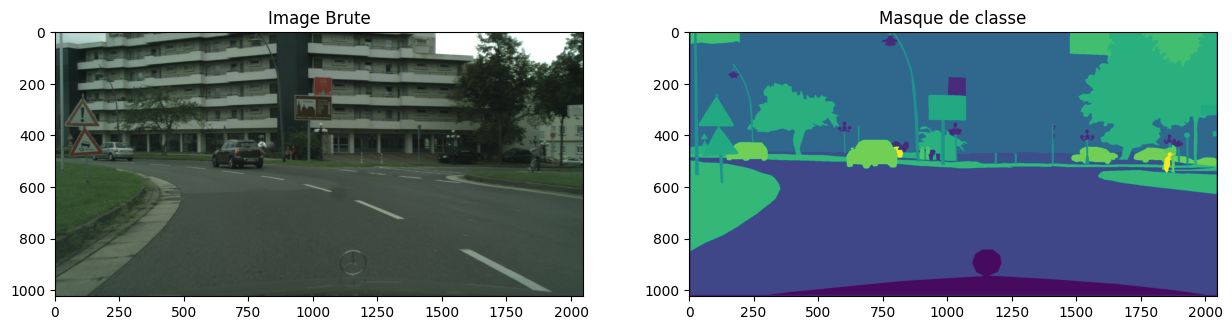

In [ ]:
# test_image = img_to_array(load_img('D:/tutorial-env/OCR/Projet8/P8_Cityscapes_data/leftImg8bit/train/aachen/aachen_000000_000019_leftImg8bit.png'))/255.
# test_mask = img_to_array(load_img('D:/tutorial-env/OCR/Projet8/P8_Cityscapes_data/gtFine/train/aachen/aachen_000000_000019_gtFine_labelIds.png',color_mode='grayscale'))
test_image = img_to_array(load_img('C:/tutorial-env/OCR/Projet8/P8_Cityscapes_data/leftImg8bit/train/aachen/aachen_000000_000019_leftImg8bit.png'))/255.
test_mask = img_to_array(load_img('C:/tutorial-env/OCR/Projet8/P8_Cityscapes_data/gtFine/train/aachen/aachen_000000_000019_gtFine_labelIds.png',color_mode='grayscale'))
test_mask = np.squeeze(test_mask)

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 2, 1)
ax.set_title('Image Brute')
ax.imshow(test_image)

ax1 = fig.add_subplot(1, 2, 2)
ax1.set_title('Masque de classe')
ax1.imshow(test_mask)

In [ ]:
# Fonction affichant le nombre de pixels d'une image selon chaque classe
def count_pixels_per_class(mask_path, class_labels):
    """
    Affiche un graphique du nombre de pixels par classe pour une image masque.

    Args:
        mask_path (str): Chemin du fichier *_gtFine_labelIds.png
        class_labels (dict): Dictionnaire {id: nom_classe}
    """
    # Chargement du masque
    mask = np.array(Image.open(mask_path))

    # Initialisation des comptes à 0 pour chaque classe
    class_counts = {cls: 0 for cls in class_labels.keys()}

    # Comptage des pixels par classe
    classes, counts = np.unique(mask, return_counts=True)
    for c in classes:
      if c in class_counts:
          class_counts[c] = counts[classes == c][0]

    # Affichage
    plt.figure(figsize=(12, 6))
    if class_labels:
        labels = [class_labels.get(c, str(c)) for c in classes]
    else:
        labels = [str(c) for c in classes]

    plt.bar(class_labels.values(), class_counts.values(), color='skyblue')
    plt.xlabel("Classe")
    plt.ylabel("Nombre de pixels")
    plt.title(f"Distribution des classes dans le masque\n{os.path.basename(mask_path)}")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

    return class_counts

In [ ]:
class_labels = {0:'0',1:'1',2:'2',3:'3',4:'4',5:'5',6:'6',7:'7',8:'8',9:'9',10:'10',
                11:'11',12:'12',13:'13',14:'14',15:'15',16:'16',17:'17',18:'18',19:'19',20:'20',
                21:'21',22:'22',23:'23',24:'24',25:'25',26:'26',27:'27',28:'28',29:'29',30:'30',
                31:'31',32:'32',33:'33'}

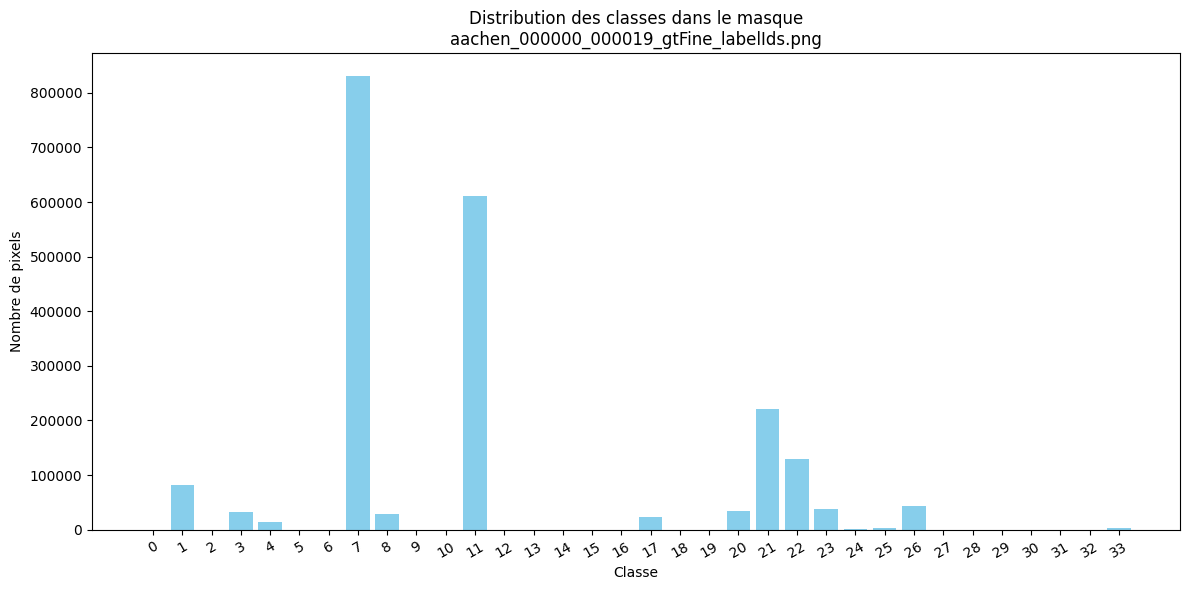

{0: 9,
 1: 81534,
 2: 0,
 3: 31634,
 4: 14664,
 5: 0,
 6: 0,
 7: 831082,
 8: 29195,
 9: 0,
 10: 0,
 11: 611938,
 12: 0,
 13: 0,
 14: 0,
 15: 0,
 16: 0,
 17: 22846,
 18: 0,
 19: 0,
 20: 34863,
 21: 221654,
 22: 130185,
 23: 38722,
 24: 1588,
 25: 2270,
 26: 42659,
 27: 0,
 28: 0,
 29: 0,
 30: 0,
 31: 0,
 32: 0,
 33: 2309}

In [ ]:
# count_pixels_per_class('D:/tutorial-env/OCR/Projet8/P8_Cityscapes_data/gtFine/train/aachen/aachen_000000_000019_gtFine_labelIds.png',class_labels)
count_pixels_per_class('C:/tutorial-env/OCR/Projet8/P8_Cityscapes_data/gtFine/train/aachen/aachen_000000_000019_gtFine_labelIds.png',class_labels)

## Regroupement de classes :

Pour simplifier la segmentation et répondre aux exigences de Franck, nous n'utiliserons pas les 33 étiquettes d'objet, mais les 8 catégories d'étiquettes : «vide», «route/trottoir», «construction», «objet», «nature» «ciel», «humain» et «véhicule».

Pour cela, avec l'aide du document officiel, nous allons effectuer le regroupement de ces classes :

In [ ]:
# Dictionnaire pour le regroupement des categories
id_to_category = {
    0: 'vide', 1: 'vide', 2: 'vide', 3: 'vide', 4: 'vide', 5: 'vide', 6: 'vide',
    7: 'route/trottoir', 8: 'route/trottoir', 9: 'route/trottoir',10: 'route/trottoir',
    11: 'construction', 12: 'construction', 13: 'construction',14: 'construction',
    15: 'construction', 16: 'construction', 17: 'objet', 18: 'objet',19: 'objet',
    20: 'objet', 21: 'nature', 22: 'nature', 23: 'ciel', 24: 'humain',25: 'humain',
    26: 'vehicule', 27: 'vehicule', 28: 'vehicule',29: 'vehicule', 30: 'vehicule',
    31: 'vehicule', 32: 'vehicule', 33: 'vehicule'
}

In [ ]:
# Fonction affichant le nombre de pixels d'une image selon chaque super-classe
def count_pixels_per_superclass(mask_path, id_to_category):
    """
    Affiche un graphique du nombre de pixels par classe pour une image masque.

    Args:
        mask_path (str): Chemin du fichier *_gtFine_labelIds.png
        class_labels (dict): Dictionnaire {id: nom_classe}
    """
    # Chargement du masque
    mask = np.array(Image.open(mask_path))

    # Initialisation des comptes à 0 pour chaque classe
    class_counts = {classe: 0 for classe in set(id_to_category.values())}

    # Comptage des pixels par classe
    classes, counts = np.unique(mask, return_counts=True)
    compteur = 0
    for c in classes:
      if c in id_to_category.keys():
        class_counts[id_to_category[c]] += counts[compteur]
        compteur += 1

    # Calcul des pourcentages
    total = sum(class_counts.values())
    class_percentages = {classe: (count / total) * 100 for classe, count in class_counts.items()}

    # Tracer le graphique
    plt.figure(figsize=(8, 6))
    bars = plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')

    # Ajouter les % au-dessus des barres
    for bar, cat in zip(bars, class_counts.keys()):
        height = bar.get_height()
        percent = class_percentages[cat]
        plt.text(bar.get_x() + bar.get_width() / 2, height + 500,
                 f"{percent:.1f}%", ha='center', va='bottom', fontsize=9)

    plt.title(f"Répartition des super-catégories\n{os.path.basename(mask_path)}")
    plt.ylabel("Nombre de pixels")
    plt.xlabel("Super-catégorie")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

    return class_counts, class_percentages


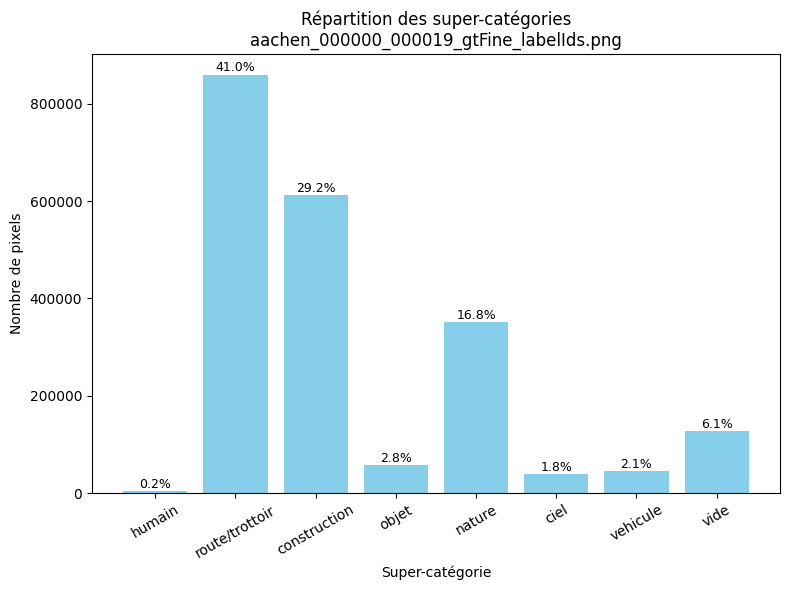

({'humain': 3858,
  'route/trottoir': 860277,
  'construction': 611938,
  'objet': 57709,
  'nature': 351839,
  'ciel': 38722,
  'vehicule': 44968,
  'vide': 127841},
 {'humain': 0.18396377563476562,
  'route/trottoir': 41.02120399475098,
  'construction': 29.17947769165039,
  'objet': 2.751779556274414,
  'nature': 16.77699089050293,
  'ciel': 1.8464088439941406,
  'vehicule': 2.1442413330078125,
  'vide': 6.09593391418457})

In [ ]:
# count_pixels_per_superclass('D:/tutorial-env/OCR/Projet8/P8_Cityscapes_data/gtFine/train/aachen/aachen_000000_000019_gtFine_labelIds.png',id_to_category)
count_pixels_per_superclass('C:/tutorial-env/OCR/Projet8/P8_Cityscapes_data/gtFine/train/aachen/aachen_000000_000019_gtFine_labelIds.png',id_to_category)

## Généralisation sur l'emsemble des images train et val :

### Train + Val

In [ ]:
 # Fonction permettant d'afficher les stats
def plot_pixel_stats_with_table(stats_dict,ax_table):
    """
    Affiche un tableau des moyennes de pixels par catégorie avec écarts-types
    et un tableau récapitulatif à côté.

    Args:
        stats_dict (dict): {cat_name: {"mean": x, "std": y}} pour chaque catégorie
    """

    categories = list(stats_dict.keys())
    nombre = [stats_dict[cat]["nombre"] for cat in categories]
    means = [stats_dict[cat]["mean"] for cat in categories]
    stds = [stats_dict[cat]["std"] for cat in categories]

    # Création du tableau de données
    df_stats = pd.DataFrame({
        "Catégorie": categories,
        "Nombre de pixels": [int(nb) for nb in nombre],
        "Moyenne de pixels": [float(m) for m in means],
        "Écart-type": [float(s) for s in stds]
    })

    # Tableau
    ax_table.axis('tight')
    ax_table.axis('off')
    table = ax_table.table(cellText=df_stats.values,
                           colLabels=df_stats.columns,
                           cellLoc='center',
                           loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)

    plt.tight_layout()
    plt.show()

In [ ]:
# Fonction affichant ladistribution de pixels d'une liste de chemins d'images selon chaque super-classe
def count_pixels_per_superclass_for_directories(liste_dir_path, id_to_category,dataset_name):
    """
    Affiche un graphique du nombre de pixels par super-catégorie et un tableau
    avec les moyennes, écarts-types et totaux pour une liste de répertoires contenant des masques.
    """

    # Initialisation
    all_class_counts = defaultdict(list)

    for dir_path in liste_dir_path:
        for racine, repertoires, fichiers in os.walk(dir_path):
            for fichier in fichiers:
                if fichier.endswith('_gtFine_labelIds.png'):
                    mask_path = os.path.join(racine, fichier)
                    mask = np.array(Image.open(mask_path))

                    # Compte local par image
                    local_counts = {cat: 0 for cat in set(id_to_category.values())}
                    classes, counts = np.unique(mask, return_counts=True)

                    for c, count in zip(classes, counts):
                        if c in id_to_category:
                            local_counts[id_to_category[c]] += count

                    # Ajout des valeurs pour les stats
                    for cat, val in local_counts.items():
                        all_class_counts[cat].append(val)

    # Calcul des stats
    total_counts = {cat: sum(vals) for cat, vals in all_class_counts.items()}
    class_percentages = {cat: (total / sum(total_counts.values())) * 100 for cat, total in total_counts.items()}
    stats_summary = {
        cat: {
            "Nombre total (millions)": int(total_counts[cat]),
            "Moyenne/image (k)": np.mean(vals)/1000,
            "Écart-type/image (k)": np.std(vals)/1000
        }
        for cat, vals in all_class_counts.items()
    }

    # === VISUALISATION ===
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Bar chart
    bars = ax1.bar(total_counts.keys(), total_counts.values(), color='skyblue')
    for bar, cat in zip(bars, total_counts.keys()):
        height = bar.get_height()
        percent = class_percentages[cat]
        ax1.text(bar.get_x() + bar.get_width() / 2, height + 10000,
                 f"{percent:.1f}%", ha='center', va='bottom', fontsize=9)

    ax1.set_title(f"Distribution des pixels par super-catégorie (jeu de données {dataset_name})")
    ax1.set_ylabel("Nombre de pixels")
    ax1.set_xlabel("Super-catégorie")
    ax1.tick_params(axis='x', rotation=30)

    # Tableau récapitulatif
    df_stats = pd.DataFrame(stats_summary).T  # On transpose pour aligner les colonnes
    df_stats = df_stats.round(2)

    ax2.axis('off')
    table = ax2.table(cellText=df_stats.values,
                      colLabels=df_stats.columns,
                      rowLabels=df_stats.index,
                      loc='center',
                      cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)

    plt.tight_layout()
    plt.show()

    return total_counts, class_percentages, stats_summary



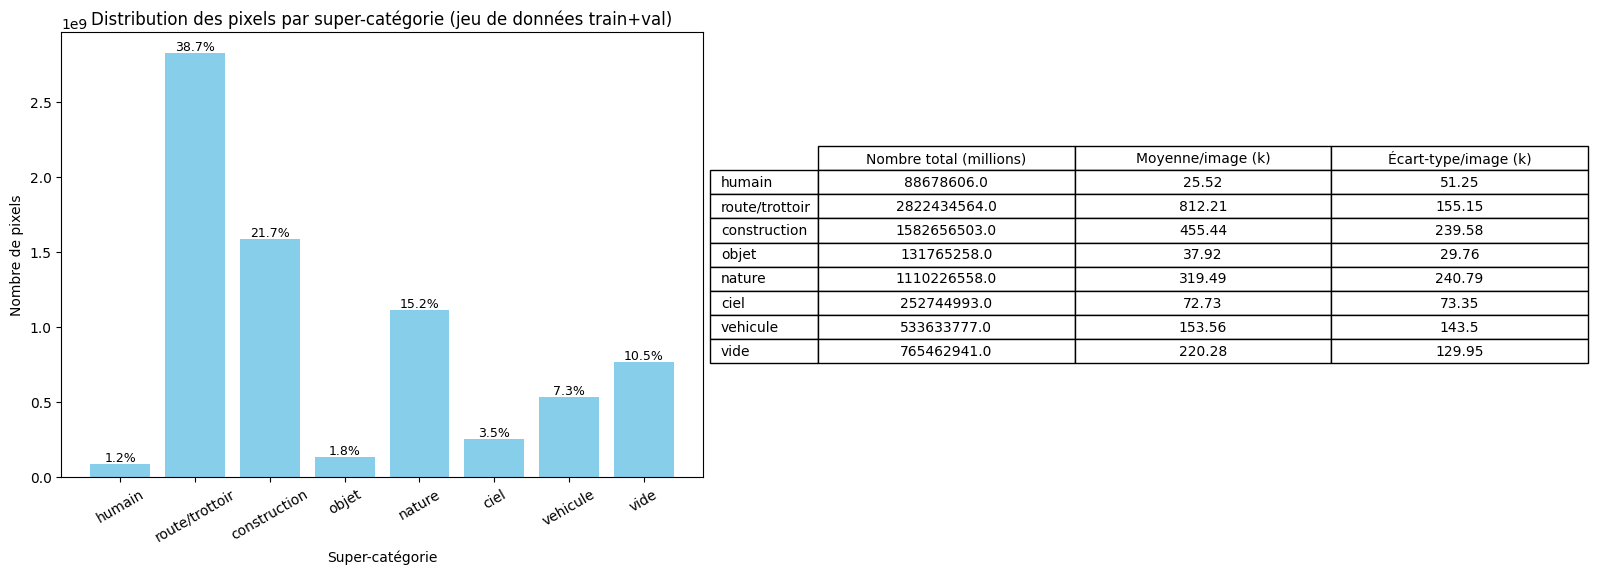

({'humain': 88678606,
  'route/trottoir': 2822434564,
  'construction': 1582656503,
  'objet': 131765258,
  'nature': 1110226558,
  'ciel': 252744993,
  'vehicule': 533633777,
  'vide': 765462941},
 {'humain': 1.2168418554950962,
  'route/trottoir': 38.7292568837996,
  'construction': 21.71710587920045,
  'objet': 1.8080739906365921,
  'nature': 15.23445401088797,
  'ciel': 3.4681497615018335,
  'vehicule': 7.322486726500148,
  'vide': 10.503630891978313},
 {'humain': {'Nombre total (millions)': 88678606,
   'Moyenne/image (k)': 25.519023309352516,
   'Écart-type/image (k)': 51.24633417193202},
  'route/trottoir': {'Nombre total (millions)': 2822434564,
   'Moyenne/image (k)': 812.211385323741,
   'Écart-type/image (k)': 155.14961658815045},
  'construction': {'Nombre total (millions)': 1582656503,
   'Moyenne/image (k)': 455.4407202877698,
   'Écart-type/image (k)': 239.58293381227696},
  'objet': {'Nombre total (millions)': 131765258,
   'Moyenne/image (k)': 37.91805985611511,
   'Éc

In [ ]:
# count_pixels_per_superclass_for_directories(['D:/tutorial-env/OCR/Projet8/P8_Cityscapes_data/gtFine/train','D:/tutorial-env/OCR/Projet8/P8_Cityscapes_data/gtFine/val'],id_to_category,'train+val')
count_pixels_per_superclass_for_directories(['C:/tutorial-env/OCR/Projet8/P8_Cityscapes_data/gtFine/train','C:/tutorial-env/OCR/Projet8/P8_Cityscapes_data/gtFine/val'],id_to_category,'train+val')


### Train

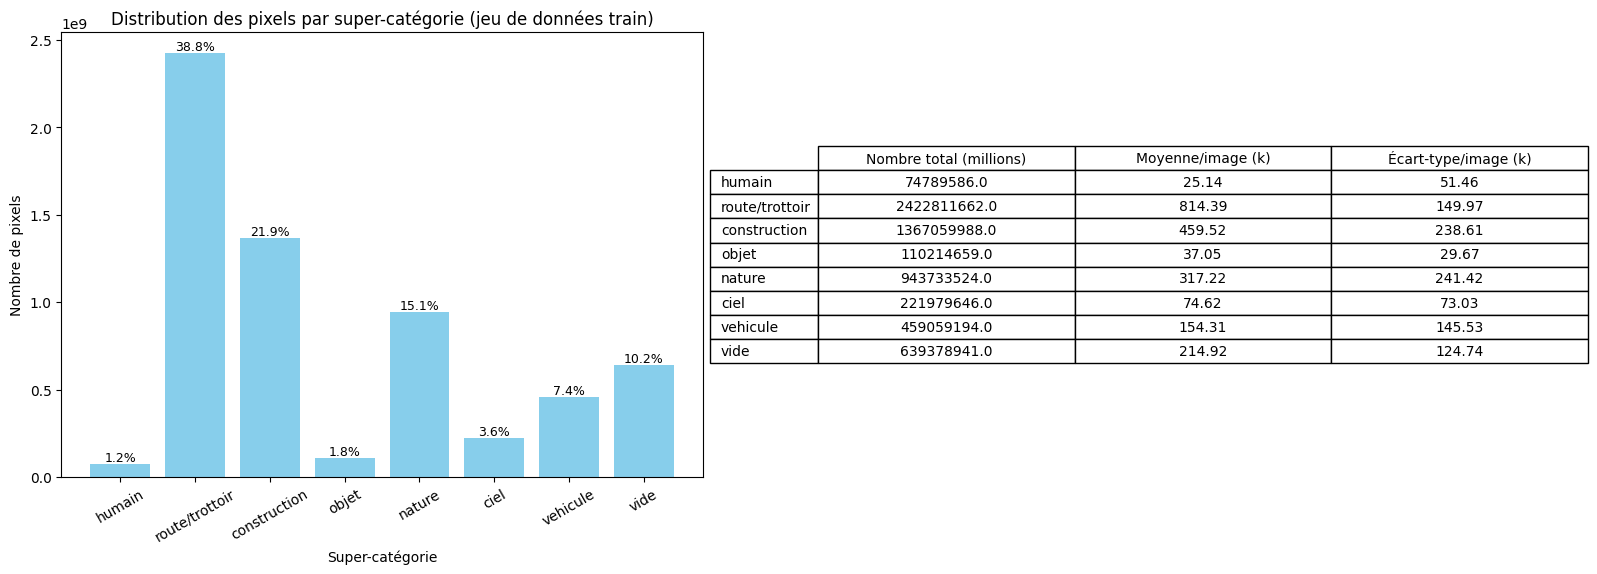

({'humain': 74789586,
  'route/trottoir': 2422811662,
  'construction': 1367059988,
  'objet': 110214659,
  'nature': 943733524,
  'ciel': 221979646,
  'vehicule': 459059194,
  'vide': 639378941},
 {'humain': 1.1987379378631335,
  'route/trottoir': 38.833163958637655,
  'construction': 21.911428563735065,
  'objet': 1.7665359593239152,
  'nature': 15.12629282975397,
  'ciel': 3.5579207925235523,
  'vehicule': 7.357864924839565,
  'vide': 10.248055033323142},
 {'humain': {'Nombre total (millions)': 74789586,
   'Moyenne/image (k)': 25.139356638655464,
   'Écart-type/image (k)': 51.46095384625044},
  'route/trottoir': {'Nombre total (millions)': 2422811662,
   'Moyenne/image (k)': 814.3904746218487,
   'Écart-type/image (k)': 149.971777086255},
  'construction': {'Nombre total (millions)': 1367059988,
   'Moyenne/image (k)': 459.5159623529412,
   'Écart-type/image (k)': 238.60731233314354},
  'objet': {'Nombre total (millions)': 110214659,
   'Moyenne/image (k)': 37.046944201680674,
   '

In [ ]:
# count_pixels_per_superclass_for_directories(['D:/tutorial-env/OCR/Projet8/P8_Cityscapes_data/gtFine/train'],id_to_category,'train')
count_pixels_per_superclass_for_directories(['C:/tutorial-env/OCR/Projet8/P8_Cityscapes_data/gtFine/train'],id_to_category,'train')

### Val

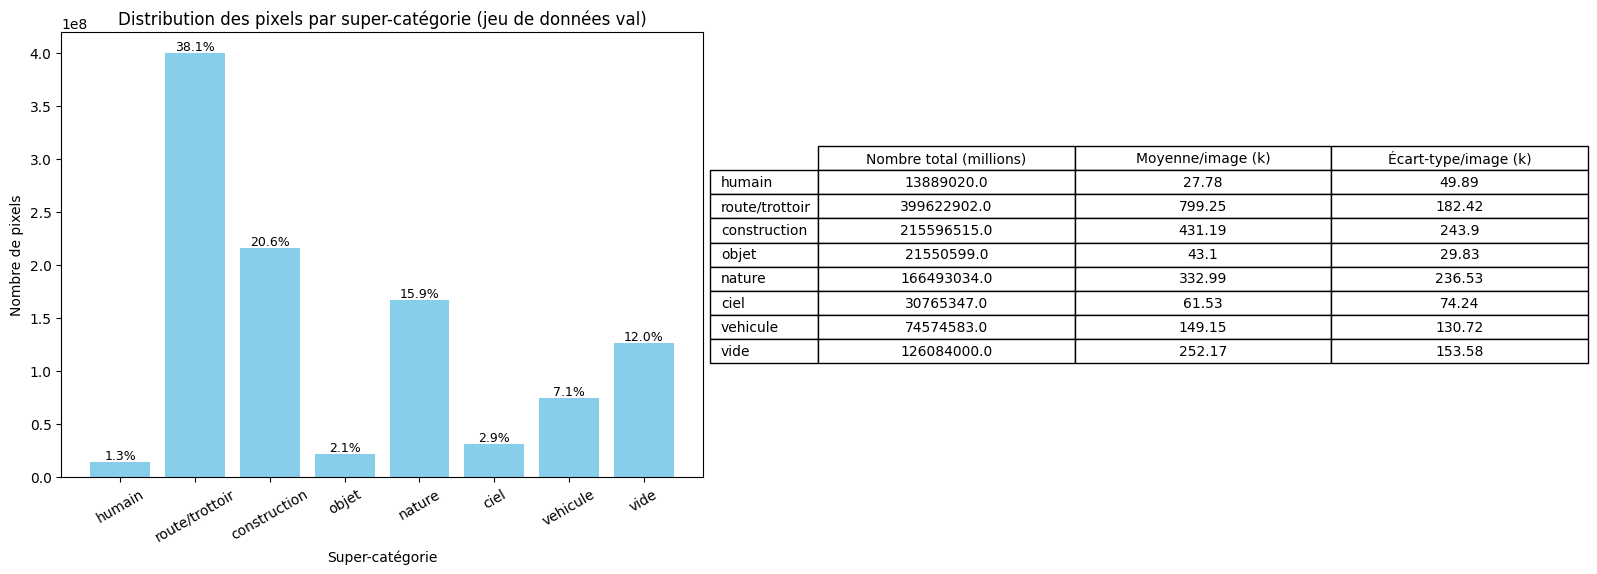

({'humain': 13889020,
  'route/trottoir': 399622902,
  'construction': 215596515,
  'objet': 21550599,
  'nature': 166493034,
  'ciel': 30765347,
  'vehicule': 74574583,
  'vide': 126084000},
 {'humain': 1.3245601654052734,
  'route/trottoir': 38.111009788513186,
  'construction': 20.560885906219482,
  'objet': 2.0552252769470214,
  'nature': 15.878013038635256,
  'ciel': 2.9340121269226076,
  'vehicule': 7.111986446380615,
  'vide': 12.024307250976562},
 {'humain': {'Nombre total (millions)': 13889020,
   'Moyenne/image (k)': 27.77804,
   'Écart-type/image (k)': 49.890580857656886},
  'route/trottoir': {'Nombre total (millions)': 399622902,
   'Moyenne/image (k)': 799.245804,
   'Écart-type/image (k)': 182.41509865927654},
  'construction': {'Nombre total (millions)': 215596515,
   'Moyenne/image (k)': 431.19303,
   'Écart-type/image (k)': 243.90384560336295},
  'objet': {'Nombre total (millions)': 21550599,
   'Moyenne/image (k)': 43.101198,
   'Écart-type/image (k)': 29.828877307783

In [ ]:
# count_pixels_per_superclass_for_directories(['D:/tutorial-env/OCR/Projet8/P8_Cityscapes_data/gtFine/val'],id_to_category,'val')
count_pixels_per_superclass_for_directories(['C:/tutorial-env/OCR/Projet8/P8_Cityscapes_data/gtFine/val'],id_to_category,'val')

Peu importe les jeu de données pris en compte, la distribution est globalement la même :    
- 39% de route/trottoir
- 21% de construction
- 16% de nature
- 11% de vide
- 7% de véhicule
- 3% de ciel
- 2% d'objet
- 1% d'humain

Mais entre ces super-catégories, il y a un déséquilibre important.